In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, \
    precision_recall_fscore_support
import multiprocessing
import random
from torch.onnx.symbolic_opset9 import tensor

multiprocessing.set_start_method('spawn', force=True)
from ml.preprocessing.ECGFeatureExtractor import DreamerECGLoader
from torch.utils.data import TensorDataset, DataLoader
import warnings
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore", message=".*DFA_alpha2.*")
import os
from datasets import Dataset
import torch.nn.functional as F

os.environ['MallocStackLogging'] = '0'
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import logging

logger = logging.getLogger(__name__)

INFO:datasets:PyTorch version 2.7.0 available.
INFO:datasets:TensorFlow version 2.18.0 available.


In [4]:
# Initialize loader
loader = DreamerECGLoader("/Users/shankarbhandari/Desktop/thesis/Experiments/ml/dataset/DREAMER.mat")

In [5]:
# Load segments with default parameters
ecg_segments, labels = loader.load_dreamer_ecg_segments()
print(f"Loaded {len(ecg_segments)} segments with shape {ecg_segments[0].shape}")

INFO:ml.preprocessing.DreamerECGLoader:Extracted 8372 segments from DREAMER


Loaded 8372 segments with shape (2560,)


In [6]:
ecg_segments

array([[ 0.28874808,  0.23980758,  0.19574264, ...,  0.09221771,
        -0.04897718, -0.15604761],
       [-0.24848406, -0.32466252, -0.38377103, ..., -0.43934618,
        -0.41280139, -0.37813632],
       [-0.35727762, -0.33317122, -0.31637442, ..., -1.7840483 ,
        -2.76249245, -3.24149663],
       ...,
       [-0.5154981 , -0.51895098, -0.52318668, ..., -0.67438865,
        -0.69038834, -0.70789012],
       [-0.72765724, -0.74587373, -0.76177646, ...,  0.34203888,
         0.39065506,  0.44076994],
       [ 0.49619947,  0.55465395,  0.62071253, ..., -0.54375145,
        -0.53430483, -0.53094242]])

In [8]:
def visualize_ecg_segment(
        ecg_segment: np.ndarray,
        sampling_rate: int = 256,
        title: str = "ECG Segment",
        figsize: Tuple[int, int] = (12, 4),
        grid: bool = True
):
    if ecg_segment.ndim != 1:
        raise ValueError("ECG segment must be 1D.")

    time_axis = np.linspace(0, len(ecg_segment) / sampling_rate, len(ecg_segment))

    plt.figure(figsize=figsize)
    plt.plot(time_axis, ecg_segment, color='blue')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    if grid:
        plt.grid(True)
    plt.tight_layout()
    plt.show()

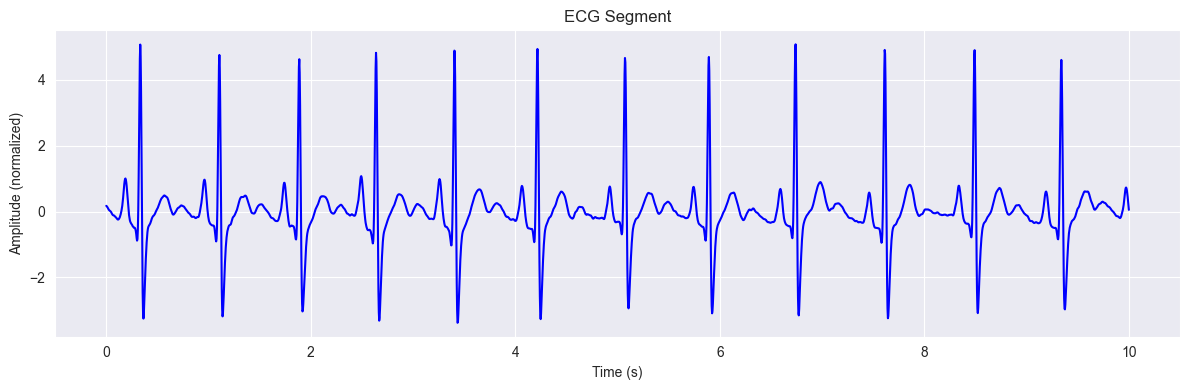

In [9]:
visualize_ecg_segment(ecg_segments[10])

In [10]:
def time_warp(x, sigma=0.2):
    """Apply time warping augmentation"""
    seq_len = x.shape[-1]
    device = x.device

    # Create original time steps on the same device
    time = torch.linspace(0, 1, seq_len, device=device)

    # Create random knot points for warping
    num_knots = max(4, seq_len // 10)
    knot_x = torch.linspace(0, 1, num_knots, device=device)
    knot_y = knot_x + torch.randn(num_knots, device=device) * sigma
    knot_y[0], knot_y[-1] = 0, 1  # Fix endpoints
    knot_y, _ = torch.sort(knot_y)  # Ensure monotonic warping

    # Manual linear interpolation
    warped_time = torch.zeros_like(time)
    for i in range(len(time)):
        t = time[i]
        # Find the two knot points that bracket this time
        idx = torch.searchsorted(knot_x, t, right=False)
        idx = torch.clamp(idx, 1, len(knot_x) - 1)

        # Linear interpolation between knot points
        x0, x1 = knot_x[idx - 1], knot_x[idx]
        y0, y1 = knot_y[idx - 1], knot_y[idx]

        if x1 - x0 > 1e-8:  # Avoid division by zero
            warped_time[i] = y0 + (y1 - y0) * (t - x0) / (x1 - x0)
        else:
            warped_time[i] = y0

    # Clamp warped_time to valid range
    warped_time = torch.clamp(warped_time, 0, 1)

    # Convert warped time back to indices
    warped_indices = warped_time * (seq_len - 1)
    warped_indices = torch.clamp(warped_indices, 0, seq_len - 1)

    # Sample the signal at warped indices using interpolation
    indices_floor = torch.floor(warped_indices).long()
    indices_ceil = torch.ceil(warped_indices).long()
    weights = warped_indices - indices_floor.float()

    # Ensure indices are within bounds
    indices_floor = torch.clamp(indices_floor, 0, seq_len - 1)
    indices_ceil = torch.clamp(indices_ceil, 0, seq_len - 1)

    # Linear interpolation between floor and ceil values
    warped_x = (1 - weights) * x[..., indices_floor] + weights * x[..., indices_ceil]

    return warped_x


def jitter(x, sigma=0.05):
    """Add Gaussian noise to the signal"""
    noise = torch.randn_like(x) * sigma
    return x + noise


class TSCCDataset(Dataset):
    """PyTorch Dataset for TS-CC contrastive learning - completely isolated implementation"""

    def __init__(self, ecg_segments):
        # Always convert to a Python list to avoid any DataLoader compatibility issues
        if isinstance(ecg_segments, np.ndarray):
            logger.info(f"Converting numpy array of shape {ecg_segments.shape} to list for TS-CC dataset")
            # Convert numpy array to list of numpy arrays for robust indexing
            self.ecg_segments = [ecg_segments[i].copy() for i in range(len(ecg_segments))]
        else:
            # Convert other formats to list
            self.ecg_segments = list(ecg_segments)

        logger.info(f"TSCCDataset initialized with {len(self.ecg_segments)} segments")

    def __len__(self):
        return len(self.ecg_segments)

    def __getitem__(self, idx):
        # Handle different index types - be more permissive
        if torch.is_tensor(idx):
            if idx.numel() == 1:
                idx = idx.item()
            else:
                # This shouldn't happen with single-item indexing
                raise ValueError(f"Multi-element tensor indexing not supported: {idx}")
        elif isinstance(idx, (list, tuple)):
            # This is batch indexing - handle it properly
            return [self.__getitem__(i) for i in idx]
        elif not isinstance(idx, int):
            idx = int(idx)

        # Get the ECG segment (now guaranteed to be from a list)
        segment = self.ecg_segments[idx]

        # Convert to tensor
        x = torch.tensor(segment, dtype=torch.float32)

        # Ensure x is 1D
        if x.dim() > 1:
            x = x.squeeze()
        if x.dim() == 0:
            x = x.unsqueeze(0)

        # Apply augmentations - create two different views
        view1 = jitter(time_warp(x))
        view2 = jitter(time_warp(x))

        # Add channel dimension for conv1d
        view1 = view1.unsqueeze(0)  # (1, seq_len)
        view2 = view2.unsqueeze(0)  # (1, seq_len)

        return view1, view2

    # Explicitly disable __getitems__ to prevent HuggingFace interference
    def __getitems__(self, indices):
        # This method should not be called by standard PyTorch DataLoader
        # But if it is, we'll handle it
        return [self.__getitem__(idx) for idx in indices]


class ECGEncoder(nn.Module):
    """Encoder network for ECG signals"""

    def __init__(self, input_dim=1, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 32, 5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, feature_dim)

    def forward(self, x):
        x = self.encoder(x).squeeze(-1)  # Remove the last dimension
        x = self.fc(x)
        return x


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning"""

    def __init__(self, input_dim=128, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)


def nt_xent_loss(z_i, z_j, temperature=0.5):
    """Normalized Temperature-scaled Cross-Entropy Loss"""
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # Shape: (2*batch_size, proj_dim)

    # Compute cosine similarity matrix
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature

    # Create mask to exclude self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, float('-inf'))

    # Create positive pairs indices
    positives = torch.cat([
        torch.arange(batch_size, device=z.device) + batch_size,
        torch.arange(batch_size, device=z.device)
    ])

    # Compute loss
    numerator = torch.exp(F.cosine_similarity(z, z[positives], dim=1) / temperature)
    denominator = torch.exp(sim).sum(dim=1)
    loss = -torch.log(numerator / denominator)

    return loss.mean()


def train_tscc(encoder, projector, dataloader, optimizer, device):
    """Training function for TS-CC"""
    encoder.train()
    projector.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (view1, view2) in enumerate(dataloader):
        try:
            view1, view2 = view1.to(device), view2.to(device)

            # Forward pass
            h_i = encoder(view1)
            h_j = encoder(view2)

            z_i = projector(h_i)
            z_j = projector(h_j)

            # Compute loss
            loss = nt_xent_loss(z_i, z_j)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            if (batch_idx + 1) % 100 == 0:
                logger.info(f"Batch {batch_idx + 1}: loss = {loss.item():.4f}")

        except Exception as e:
            logger.error(f"Error in batch {batch_idx}: {e}")
            continue

    return total_loss / max(num_batches, 1)


def extract_tscc_features(encoder, ecg_segments, device, batch_size=64):
    """Extract features from pretrained encoder - optimized for numpy arrays"""

    encoder_path = "/Users/shankarbhandari/Desktop/thesis/Experiments/ml/lab/dreamer_tscc_encoder.pth"
    if os.path.exists(encoder_path):
        print(f"Found pretrained encoder at {encoder_path}, loading...")
        encoder.load_state_dict(torch.load(encoder_path, map_location=device))
    encoder.eval()
    features = []

    total_samples = len(ecg_segments)
    logger.info(f"Extracting features from {total_samples} segments...")

    with torch.no_grad():
        for i in range(0, total_samples, batch_size):
            end_idx = min(i + batch_size, total_samples)
            batch_segments = ecg_segments[i:end_idx]
            batch_tensors = []

            for seg in batch_segments:
                # Convert to tensor and ensure proper shape
                x = torch.tensor(seg, dtype=torch.float32)
                if x.dim() == 1:
                    x = x.unsqueeze(0)  # Add channel dimension: (1, seq_len)
                elif x.dim() > 2:
                    x = x.squeeze()
                    if x.dim() == 1:
                        x = x.unsqueeze(0)

                batch_tensors.append(x)

            # Stack into batch
            batch = torch.stack(batch_tensors).to(device)  # (batch_size, 1, seq_len)

            # Extract features
            batch_features = encoder(batch)  # (batch_size, feature_dim)
            features.append(batch_features.cpu())

            if (i // batch_size + 1) % 10 == 0:
                logger.info(f"Processed {end_idx}/{total_samples} segments")

    return encoder, torch.cat(features, dim=0)


In [11]:
encoder = ECGEncoder(feature_dim=128).to(device)
projector = ProjectionHead(input_dim=128, proj_dim=64).to(device)
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(projector.parameters()),
    lr=1e-3
)


def run_dreamer_tscc_pipeline(ecg_segments, labels, device, epochs=10, task='valence'):
    global encoder
    print(f"Starting TS-CC pipeline with {len(ecg_segments)} segments")
    print(f"ECG segments shape: {ecg_segments.shape}")
    print(f"Labels shape: {labels.shape}")

    encoder_path = "/Users/shankarbhandari/Desktop/thesis/Experiments/ml/lab/dreamer_tscc_encoder.pth"

    # Check if pretrained encoder exists
    if os.path.exists(encoder_path):
        return extract_tscc_features(encoder, ecg_segments, device=device)
    else:
        print("No pretrained encoder found, training TS-CC from scratch...")

        # Step 1: Pretrain with TS-CC
        print("Starting TS-CC pretraining...")
        tscc_dataset = TSCCDataset(ecg_segments)

        # Use the simplest possible DataLoader configuration
        tscc_loader = DataLoader(
            tscc_dataset,
            batch_size=32,
            shuffle=True,
            num_workers=0,  # Always use 0 to avoid multiprocessing issues
            drop_last=True,  # Drop incomplete batches
        )

        # Training loop
        for epoch in range(epochs):
            loss = train_tscc(encoder, projector, tscc_loader, optimizer, device)
            print(f"TS-CC Epoch {epoch + 1}/{epochs}: loss={loss:.4f}")

        # Save encoder
        torch.save(encoder.state_dict(), encoder_path)
        print("TS-CC pretraining completed!")

        # Now extract features
        encoder, features = extract_tscc_features(ecg_segments, device)

    print(f"Extracted {features.shape[0]} features of dimension {features.shape[1]} for {task} task")
    return encoder, features


In [12]:
encoder, features = run_dreamer_tscc_pipeline(ecg_segments, labels, device)

INFO:__main__:Extracting features from 8372 segments...


Starting TS-CC pipeline with 8372 segments
ECG segments shape: (8372, 2560)
Labels shape: (8372, 3)
Found pretrained encoder at /Users/shankarbhandari/Desktop/thesis/Experiments/ml/lab/dreamer_tscc_encoder.pth, loading...


INFO:__main__:Processed 640/8372 segments
INFO:__main__:Processed 1280/8372 segments
INFO:__main__:Processed 1920/8372 segments
INFO:__main__:Processed 2560/8372 segments
INFO:__main__:Processed 3200/8372 segments
INFO:__main__:Processed 3840/8372 segments
INFO:__main__:Processed 4480/8372 segments
INFO:__main__:Processed 5120/8372 segments
INFO:__main__:Processed 5760/8372 segments
INFO:__main__:Processed 6400/8372 segments
INFO:__main__:Processed 7040/8372 segments
INFO:__main__:Processed 7680/8372 segments
INFO:__main__:Processed 8320/8372 segments


In [10]:
#Extract features
logger.info("Extracting features for task...")
encoder, extracted_features = extract_tscc_features(encoder, ecg_segments, device)

INFO:__main__:Extracting features for task...
INFO:__main__:Extracting features from 8372 segments...


Found pretrained encoder at /Users/shankarbhandari/Desktop/thesis/Experiments/ml/lab/dreamer_tscc_encoder.pth, loading...


INFO:__main__:Processed 640/8372 segments
INFO:__main__:Processed 1280/8372 segments
INFO:__main__:Processed 1920/8372 segments
INFO:__main__:Processed 2560/8372 segments
INFO:__main__:Processed 3200/8372 segments
INFO:__main__:Processed 3840/8372 segments
INFO:__main__:Processed 4480/8372 segments
INFO:__main__:Processed 5120/8372 segments
INFO:__main__:Processed 5760/8372 segments
INFO:__main__:Processed 6400/8372 segments
INFO:__main__:Processed 7040/8372 segments
INFO:__main__:Processed 7680/8372 segments
INFO:__main__:Processed 8320/8372 segments


In [10]:
features

tensor([[ 0.4037,  0.1572, -0.1986,  ..., -0.1717,  0.1121,  0.0131],
        [ 0.3962,  0.1468, -0.1809,  ..., -0.1789,  0.0932,  0.0101],
        [ 0.3796,  0.1226, -0.1838,  ..., -0.1693,  0.0696,  0.0129],
        ...,
        [ 0.2383,  0.0844, -0.0929,  ...,  0.0268, -0.0066, -0.0309],
        [ 0.2427,  0.0904, -0.1040,  ...,  0.0311,  0.0004, -0.0323],
        [ 0.2367,  0.0856, -0.0995,  ...,  0.0398, -0.0039, -0.0283]])

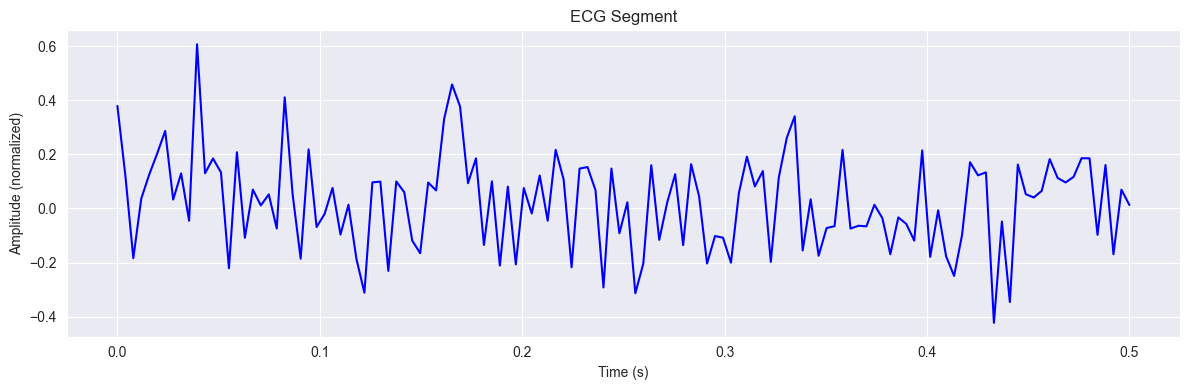

In [11]:
visualize_ecg_segment(features[2])

In [22]:
class TSCCFeatureDataset(Dataset):
    """Dataset for TS-CC features with emotion labels"""

    def __init__(self, features, labels, task_names=['valence', 'arousal', 'dominance']):
        """
        features: torch.Tensor or array-like of shape (n_samples, feature_dim) - TS-CC features
        labels: np.array of shape (n_samples, 3) - [valence, arousal, dominance] labels
        """
        # Disable automatic batching to force single-index calls
        self.__getitems__ = None
        # Convert features to tensor list
        if isinstance(features, torch.Tensor):
            self._features = [features[i].clone() for i in range(len(features))]
        else:
            self._features = [torch.tensor(feat, dtype=torch.float32) for feat in features]

        self.task_names = task_names

        # Handle labels
        if isinstance(labels, np.ndarray):
            if labels.ndim == 1:
                # Single task labels
                self._labels = [torch.tensor(labels[i], dtype=torch.long) for i in range(len(labels))]
            else:
                # Multi-task labels - convert to classes
                processed_labels = self._convert_labels_to_classes(labels)
                self._labels = [torch.tensor(processed_labels[i], dtype=torch.long) for i in
                                range(len(processed_labels))]
        else:
            self._labels = [torch.tensor(label, dtype=torch.long) for label in labels]

        print(f"Dataset created with {len(self._features)} samples")
        print(f"Feature dimension: {self._features[0].shape[0]}")
        print(f"Label shape: {self._labels[0].shape}")

    def _convert_labels_to_classes(self, labels):
        """Convert continuous emotion labels to discrete classes"""
        class_labels = np.zeros_like(labels, dtype=np.int64)

        for i in range(labels.shape[1]):  # For each emotion dimension
            task_labels = labels[:, i]
            # Define thresholds for 3 classes using percentiles
            low_thresh = np.percentile(task_labels, 33)
            high_thresh = np.percentile(task_labels, 67)

            class_labels[:, i] = np.where(
                task_labels <= low_thresh, 0,
                np.where(task_labels <= high_thresh, 1, 2)
            )

        # Print class distribution
        for i in range(class_labels.shape[1]):
            unique, counts = np.unique(class_labels[:, i], return_counts=True)
            print(f"Task {i} ({self.task_names[i] if i < len(self.task_names) else f'task_{i}'}) "
                  f"class distribution: {dict(zip(unique, counts))}")

        return class_labels

    def __len__(self):
        return len(self._features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        # Ensure idx is a single integer
        if isinstance(idx, list):
            raise TypeError("This dataset only supports single integer indices")

        feature = self._features[idx]
        label = self._labels[idx]
        return feature, label



In [24]:
def custom_collate_fn(batch):
    """Custom collate function to safely stack tensors."""
    features, labels = zip(*batch)

    # Convert everything to tensors safely
    features_tensor = torch.stack([
        torch.as_tensor(f, dtype=torch.float32) for f in features
    ])
    labels_tensor = torch.stack([
        torch.as_tensor(l, dtype=torch.float32) for l in labels
    ])
    return features_tensor, labels_tensor


def create_feature_dataloaders(tscc_features, emotion_labels, batch_size=32, test_size=0.2, random_state=42):
    """Create train/val dataloaders from TS-CC features and emotion labels"""

    print("Creating feature dataloaders...")

    # Convert to numpy for splitting
    features_np = np.array(tscc_features) if not isinstance(tscc_features, torch.Tensor) else tscc_features.numpy()
    labels_np = np.array(emotion_labels) if not isinstance(emotion_labels, torch.Tensor) else emotion_labels.numpy()

    print(f"Input shapes - Features: {features_np.shape}, Labels: {labels_np.shape}")

    # Choose stratification column if labels are multi-dimensional
    stratify_col = labels_np[:, 0] if labels_np.ndim > 1 else labels_np

    # Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        features_np,
        labels_np,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_col
    )

    print(f"Train split: {X_train.shape[0]} samples")
    print(f"Validation split: {X_val.shape[0]} samples")

    # Convert back to tensors
    X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.as_tensor(X_val, dtype=torch.float32)

    print(f"Train tensor shape: {X_train_tensor.shape}")
    print(f"Validation tensor shape: {X_val_tensor.shape}")

    # Create datasets
    print("\nCreating train dataset...")
    train_dataset = TSCCFeatureDataset(X_train_tensor, y_train)

    print("\nCreating validation dataset...")
    val_dataset = TSCCFeatureDataset(X_val_tensor, y_val)

    # DataLoaders with safe collate function
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        drop_last=False,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    return train_loader, val_loader


In [25]:
# Step 1: Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader = create_feature_dataloaders(features, labels)

Creating dataloaders...
Creating feature dataloaders...
Input shapes - Features: (8372, 128), Labels: (8372, 3)
Train split: 6697 samples
Validation split: 1675 samples
Train tensor shape: torch.Size([6697, 128])
Validation tensor shape: torch.Size([1675, 128])

Creating train dataset...
Task 0 (valence) class distribution: {np.int64(0): np.int64(2620), np.int64(1): np.int64(2970), np.int64(2): np.int64(1107)}
Task 1 (arousal) class distribution: {np.int64(0): np.int64(3501), np.int64(1): np.int64(2333), np.int64(2): np.int64(863)}
Task 2 (dominance) class distribution: {np.int64(0): np.int64(3127), np.int64(1): np.int64(2390), np.int64(2): np.int64(1180)}
Dataset created with 6697 samples
Feature dimension: 128
Label shape: torch.Size([3])

Creating validation dataset...
Task 0 (valence) class distribution: {np.int64(0): np.int64(656), np.int64(1): np.int64(743), np.int64(2): np.int64(276)}
Task 1 (arousal) class distribution: {np.int64(0): np.int64(856), np.int64(1): np.int64(601), n

In [58]:
import torch.nn as nn
import torch.nn.functional as F


class SimplePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(max_len, d_model) * 0.02)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:seq_len].unsqueeze(0)


class SimpleTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x


class SimpleECGTransformer(nn.Module):
    def __init__(self, input_dim=128, d_model=256, nhead=8, num_layers=6, num_classes=3, dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = SimplePositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            SimpleTransformerLayer(d_model, nhead) for _ in range(num_layers)
        ])

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch, seq_len=1, features)

        x = self.input_proj(x)
        x = self.pos_enc(x)

        # Add CLS token at front
        cls_token = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        for layer in self.layers:
            x = layer(x)

        cls_output = x[:, 0]  # take CLS representation
        logits = self.fc(cls_output)
        return logits


In [94]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

model = SimpleECGTransformer(
    input_dim=128,
    num_classes=3,
    dropout=0.2,
    d_model=128,
    nhead=8,
    num_layers=8
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.03)
criterion = nn.CrossEntropyLoss()

# Store metrics for plotting
train_losses = []
train_accuracies = []

for epoch in range(300):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for xb, yb in train_loader:
        if yb.ndim > 1:  # convert one-hot to indices if needed
            yb = torch.argmax(yb, dim=1)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.8599, Accuracy: 0.6799
Epoch 2, Loss: 0.8395, Accuracy: 0.6814
Epoch 3, Loss: 0.8344, Accuracy: 0.6815
Epoch 4, Loss: 0.8178, Accuracy: 0.6812
Epoch 5, Loss: 0.7997, Accuracy: 0.6806
Epoch 6, Loss: 0.7868, Accuracy: 0.6818
Epoch 7, Loss: 0.7785, Accuracy: 0.6803
Epoch 8, Loss: 0.7633, Accuracy: 0.6830
Epoch 9, Loss: 0.7563, Accuracy: 0.6832
Epoch 10, Loss: 0.7473, Accuracy: 0.6836
Epoch 11, Loss: 0.7364, Accuracy: 0.6874
Epoch 12, Loss: 0.7325, Accuracy: 0.6909
Epoch 13, Loss: 0.7254, Accuracy: 0.6933
Epoch 14, Loss: 0.7158, Accuracy: 0.6923
Epoch 15, Loss: 0.7139, Accuracy: 0.6911
Epoch 16, Loss: 0.7103, Accuracy: 0.6933
Epoch 17, Loss: 0.7017, Accuracy: 0.6977
Epoch 18, Loss: 0.7010, Accuracy: 0.6944
Epoch 19, Loss: 0.7004, Accuracy: 0.6966
Epoch 20, Loss: 0.6920, Accuracy: 0.7014
Epoch 21, Loss: 0.6872, Accuracy: 0.7002
Epoch 22, Loss: 0.6860, Accuracy: 0.6971
Epoch 23, Loss: 0.6806, Accuracy: 0.7032
Epoch 24, Loss: 0.6791, Accuracy: 0.7011
Epoch 25, Loss: 0.6690, A

In [95]:
# ----- Classification Report -----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        if yb.ndim > 1:
            yb = torch.argmax(yb, dim=1)

        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7995    0.8878    0.8414      1123
           1     0.6210    0.4828    0.5432       319
           2     0.5944    0.4592    0.5182       233

    accuracy                         0.7510      1675
   macro avg     0.6716    0.6099    0.6342      1675
weighted avg     0.7370    0.7510    0.7396      1675



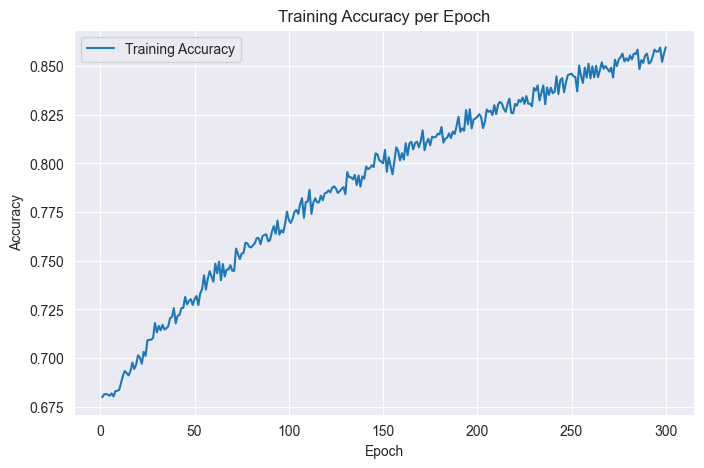

In [96]:
# ----- Plot Epoch vs Accuracy -----
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

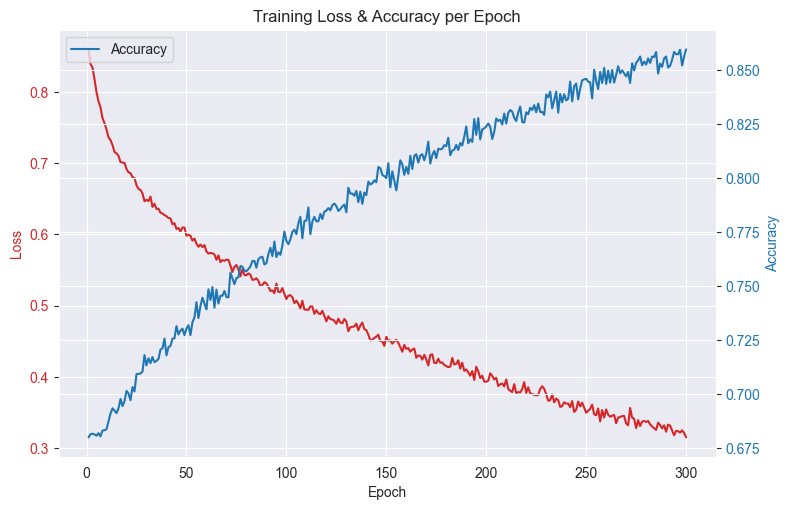

In [97]:
# --- Plot accuracy and loss ---
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(train_losses) + 1), train_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # share x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Training Loss & Accuracy per Epoch")
plt.legend()
plt.show()

In [98]:
model

SimpleECGTransformer(
  (input_proj): Linear(in_features=128, out_features=128, bias=True)
  (pos_enc): SimplePositionalEncoding()
  (dropout): Dropout(p=0.2, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x SimpleTransformerLayer(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

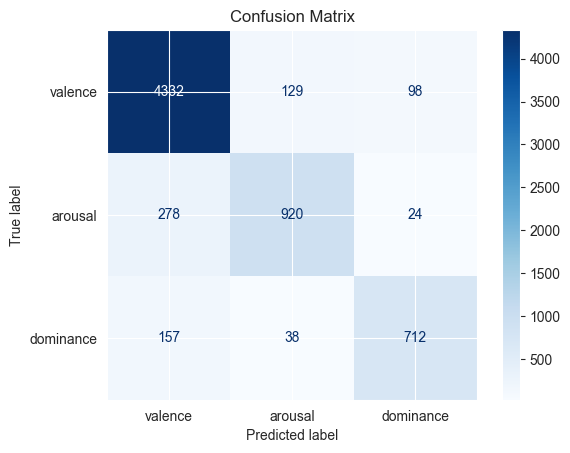

In [99]:
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score

# ------------------------
# Confusion matrix
# ------------------------
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in train_loader:
        if yb.ndim > 1:
            yb = torch.argmax(yb, dim=1)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['valence', 'arousal', 'dominance'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


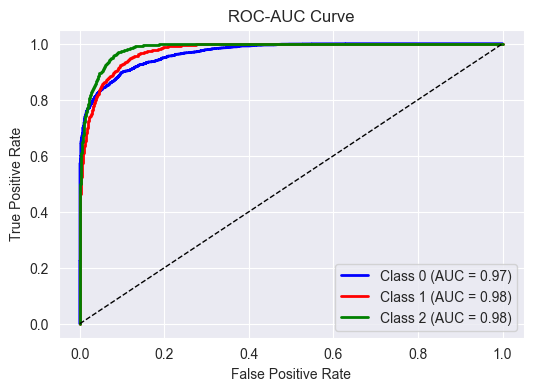

In [100]:
# ------------------------
# ROC-AUC Curve (One-vs-Rest for multi-class)
# ------------------------
all_labels_onehot = np.eye(model.num_classes)[all_labels]
all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = model.num_classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(all_labels_onehot[:, i], all_probs[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(6, 4))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()